In [52]:
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename

## SET PARAMETERS

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [53]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

### Generate maps of metadata, and check if initial sites is a logical choice

In [54]:
# TODO: Figure out good way to use testing data for example analysis...
# for now just use copied files from denali screen

TEST_WELL = "B1"
TEST_CYCLE = 1

In [55]:
ph_test_metadata_fp = f"{ROOT_FP}/preprocess/metadata/phenotype/" + get_filename(
    {"well": TEST_WELL}, "combined_metadata", "tsv"
)
ph_test_metadata = pd.read_csv(ph_test_metadata_fp, sep="\t")

sbs_test_metadata_fp = f"{ROOT_FP}/preprocess/metadata/sbs/" + get_filename(
    {"well": TEST_WELL, "cycle": TEST_CYCLE}, "combined_metadata", "tsv"
)
sbs_test_metadata = pd.read_csv(sbs_test_metadata_fp, sep="\t")
sbs_test_metadata

# TODO: Address this properly in metadata extraction
# convert the lists in the x,y,z data to numbers
# ph_test_metadata[['x_data', 'y_data', 'z_data']] = ph_test_metadata[['x_data', 'y_data', 'z_data']].applymap(lambda x: float(x.strip("[]")))
# sbs_test_metadata[['x_data', 'y_data', 'z_data']] = sbs_test_metadata[['x_data', 'y_data', 'z_data']].applymap(lambda x: float(x.strip("[]")))

,x_pos,y_pos,z_pos,pfs_offset,tile,filename,width,height,pixel_size_x,pixel_size_y
0,38953.7,2305.9,3121.78,8063,0,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
1,33037.5,3835.2,3120.10,8063,1,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
2,34519.6,3823.1,3120.14,8063,2,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
3,36001.5,3811.2,3120.12,8063,3,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
4,37483.4,3799.5,3120.14,8063,4,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
...,...,...,...,...,...,...,...,...,...,...
372,40684.8,33415.1,3145.72,8063,372,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
373,42166.7,33402.8,3145.70,8063,373,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
374,43648.9,33391.0,3145.70,8063,374,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3
375,45130.8,33379.0,3145.72,8063,375,/lab/barcheese01/screens/denali/input_sbs/c1/P...,2400,2400,1.3,1.3


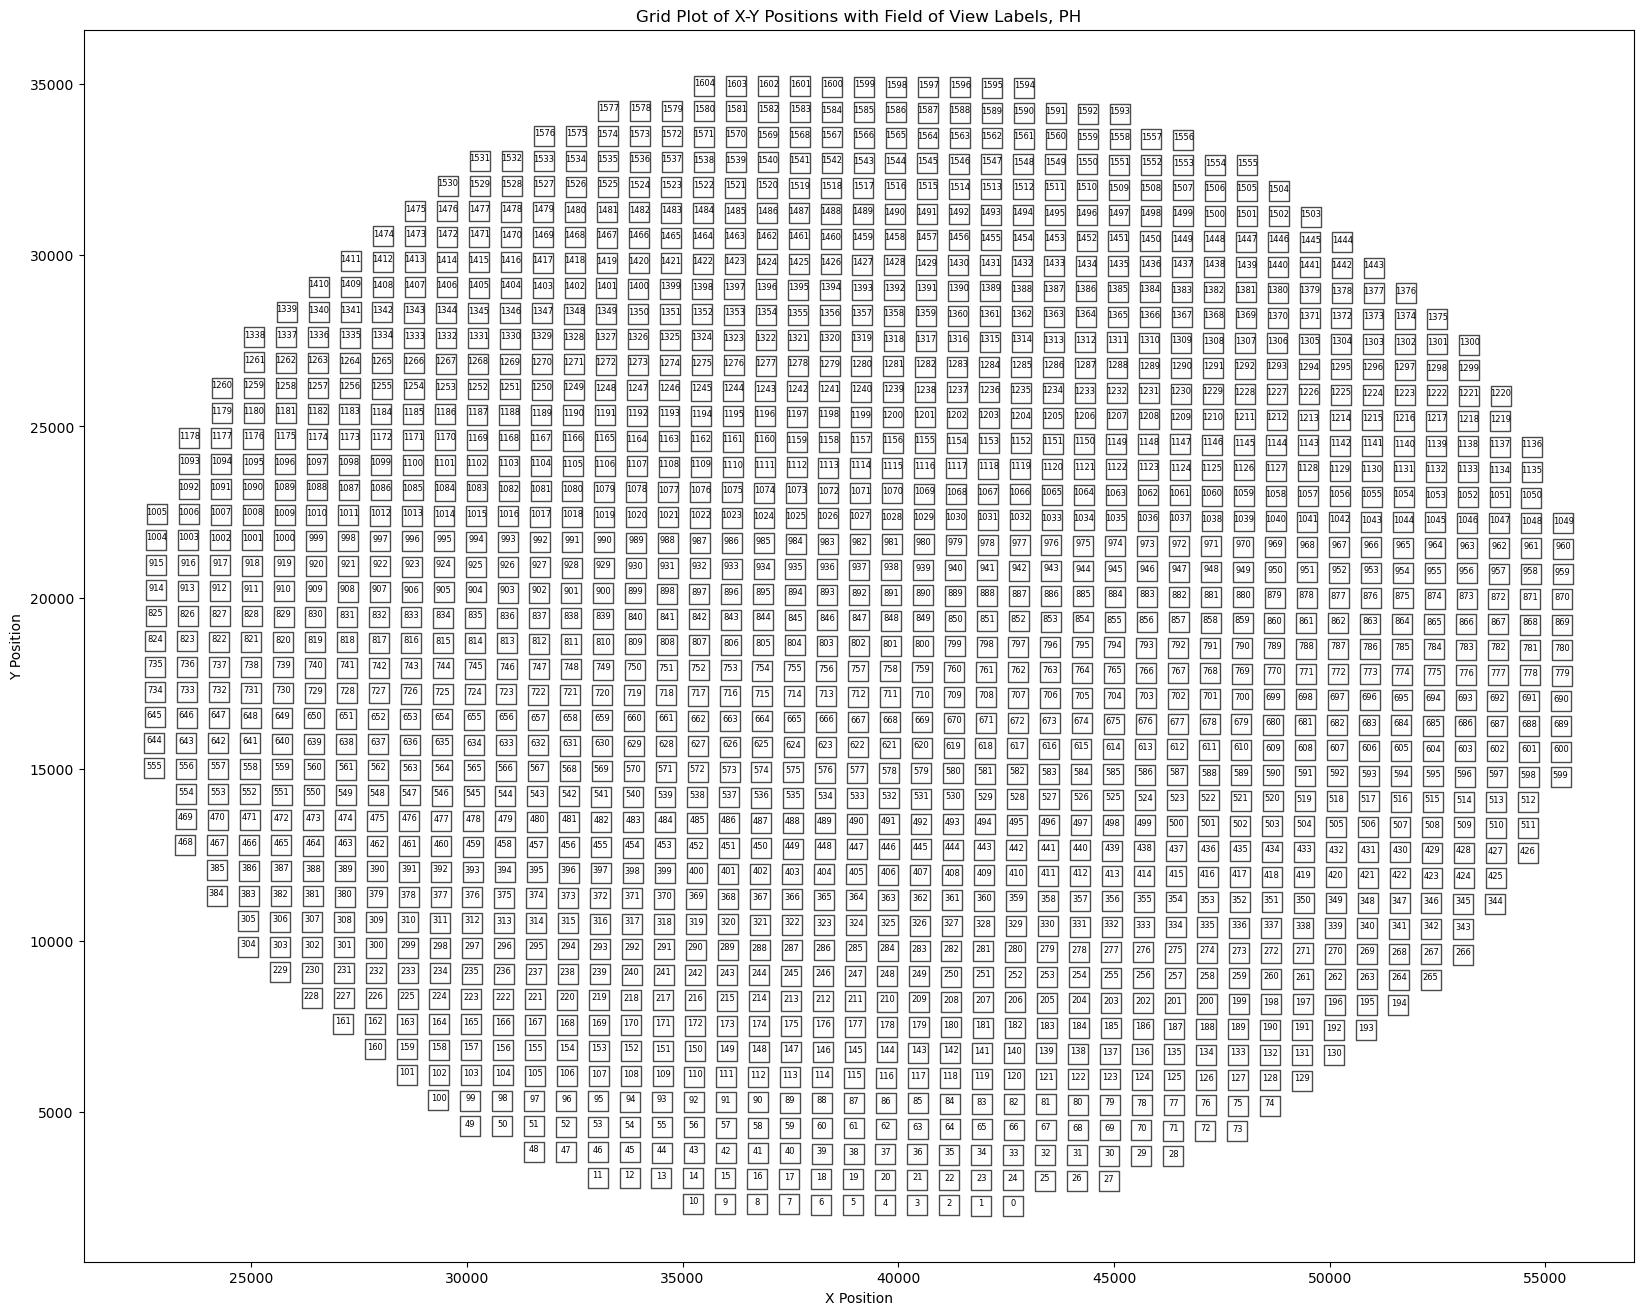

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))

# Scatter plot with dynamically sized squares for each point
plt.scatter(
    ph_test_metadata["x_pos"],
    ph_test_metadata["y_pos"],
    s=200,
    c="white",
    marker="s",
    edgecolors="black",
    linewidths=1,
    alpha=0.7,
)

# Label each point with the 'tile' variable
for i, txt in enumerate(ph_test_metadata["tile"]):
    plt.annotate(
        txt,
        (ph_test_metadata["x_pos"].iloc[i], ph_test_metadata["y_pos"].iloc[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
        fontsize=6,
    )

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Grid Plot of X-Y Positions with Field of View Labels, PH")
plt.show()

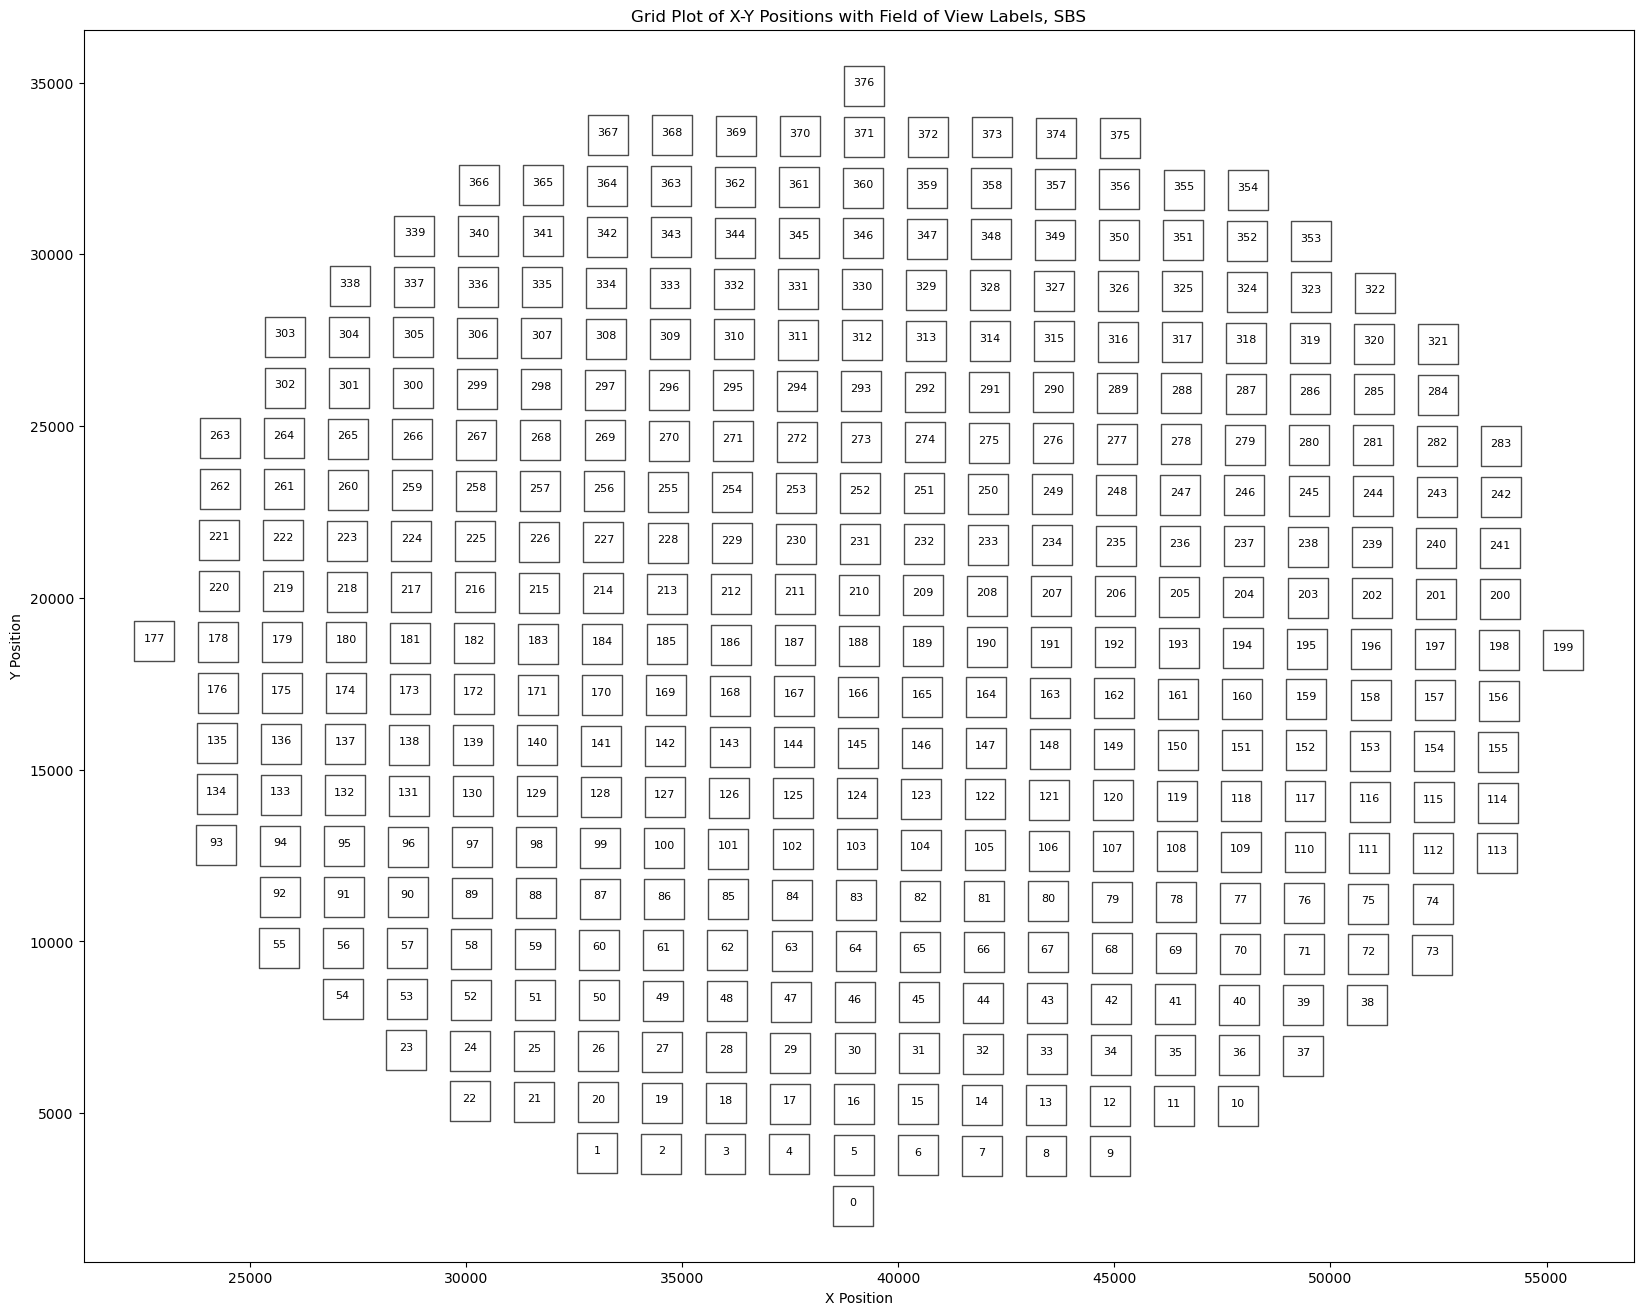

In [70]:
plt.figure(figsize=(20, 16))

# Scatter plot with squares for each point
plt.scatter(
    sbs_test_metadata["x_pos"],
    sbs_test_metadata["y_pos"],
    s=800,
    c="white",
    marker="s",
    edgecolors="black",
    linewidths=1,
    alpha=0.7,
)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata["tile"]):
    plt.annotate(
        txt,
        (sbs_test_metadata["x_pos"].iloc[i], sbs_test_metadata["y_pos"].iloc[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
        fontsize=8,
    )
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Grid Plot of X-Y Positions with Field of View Labels, SBS")
plt.show()

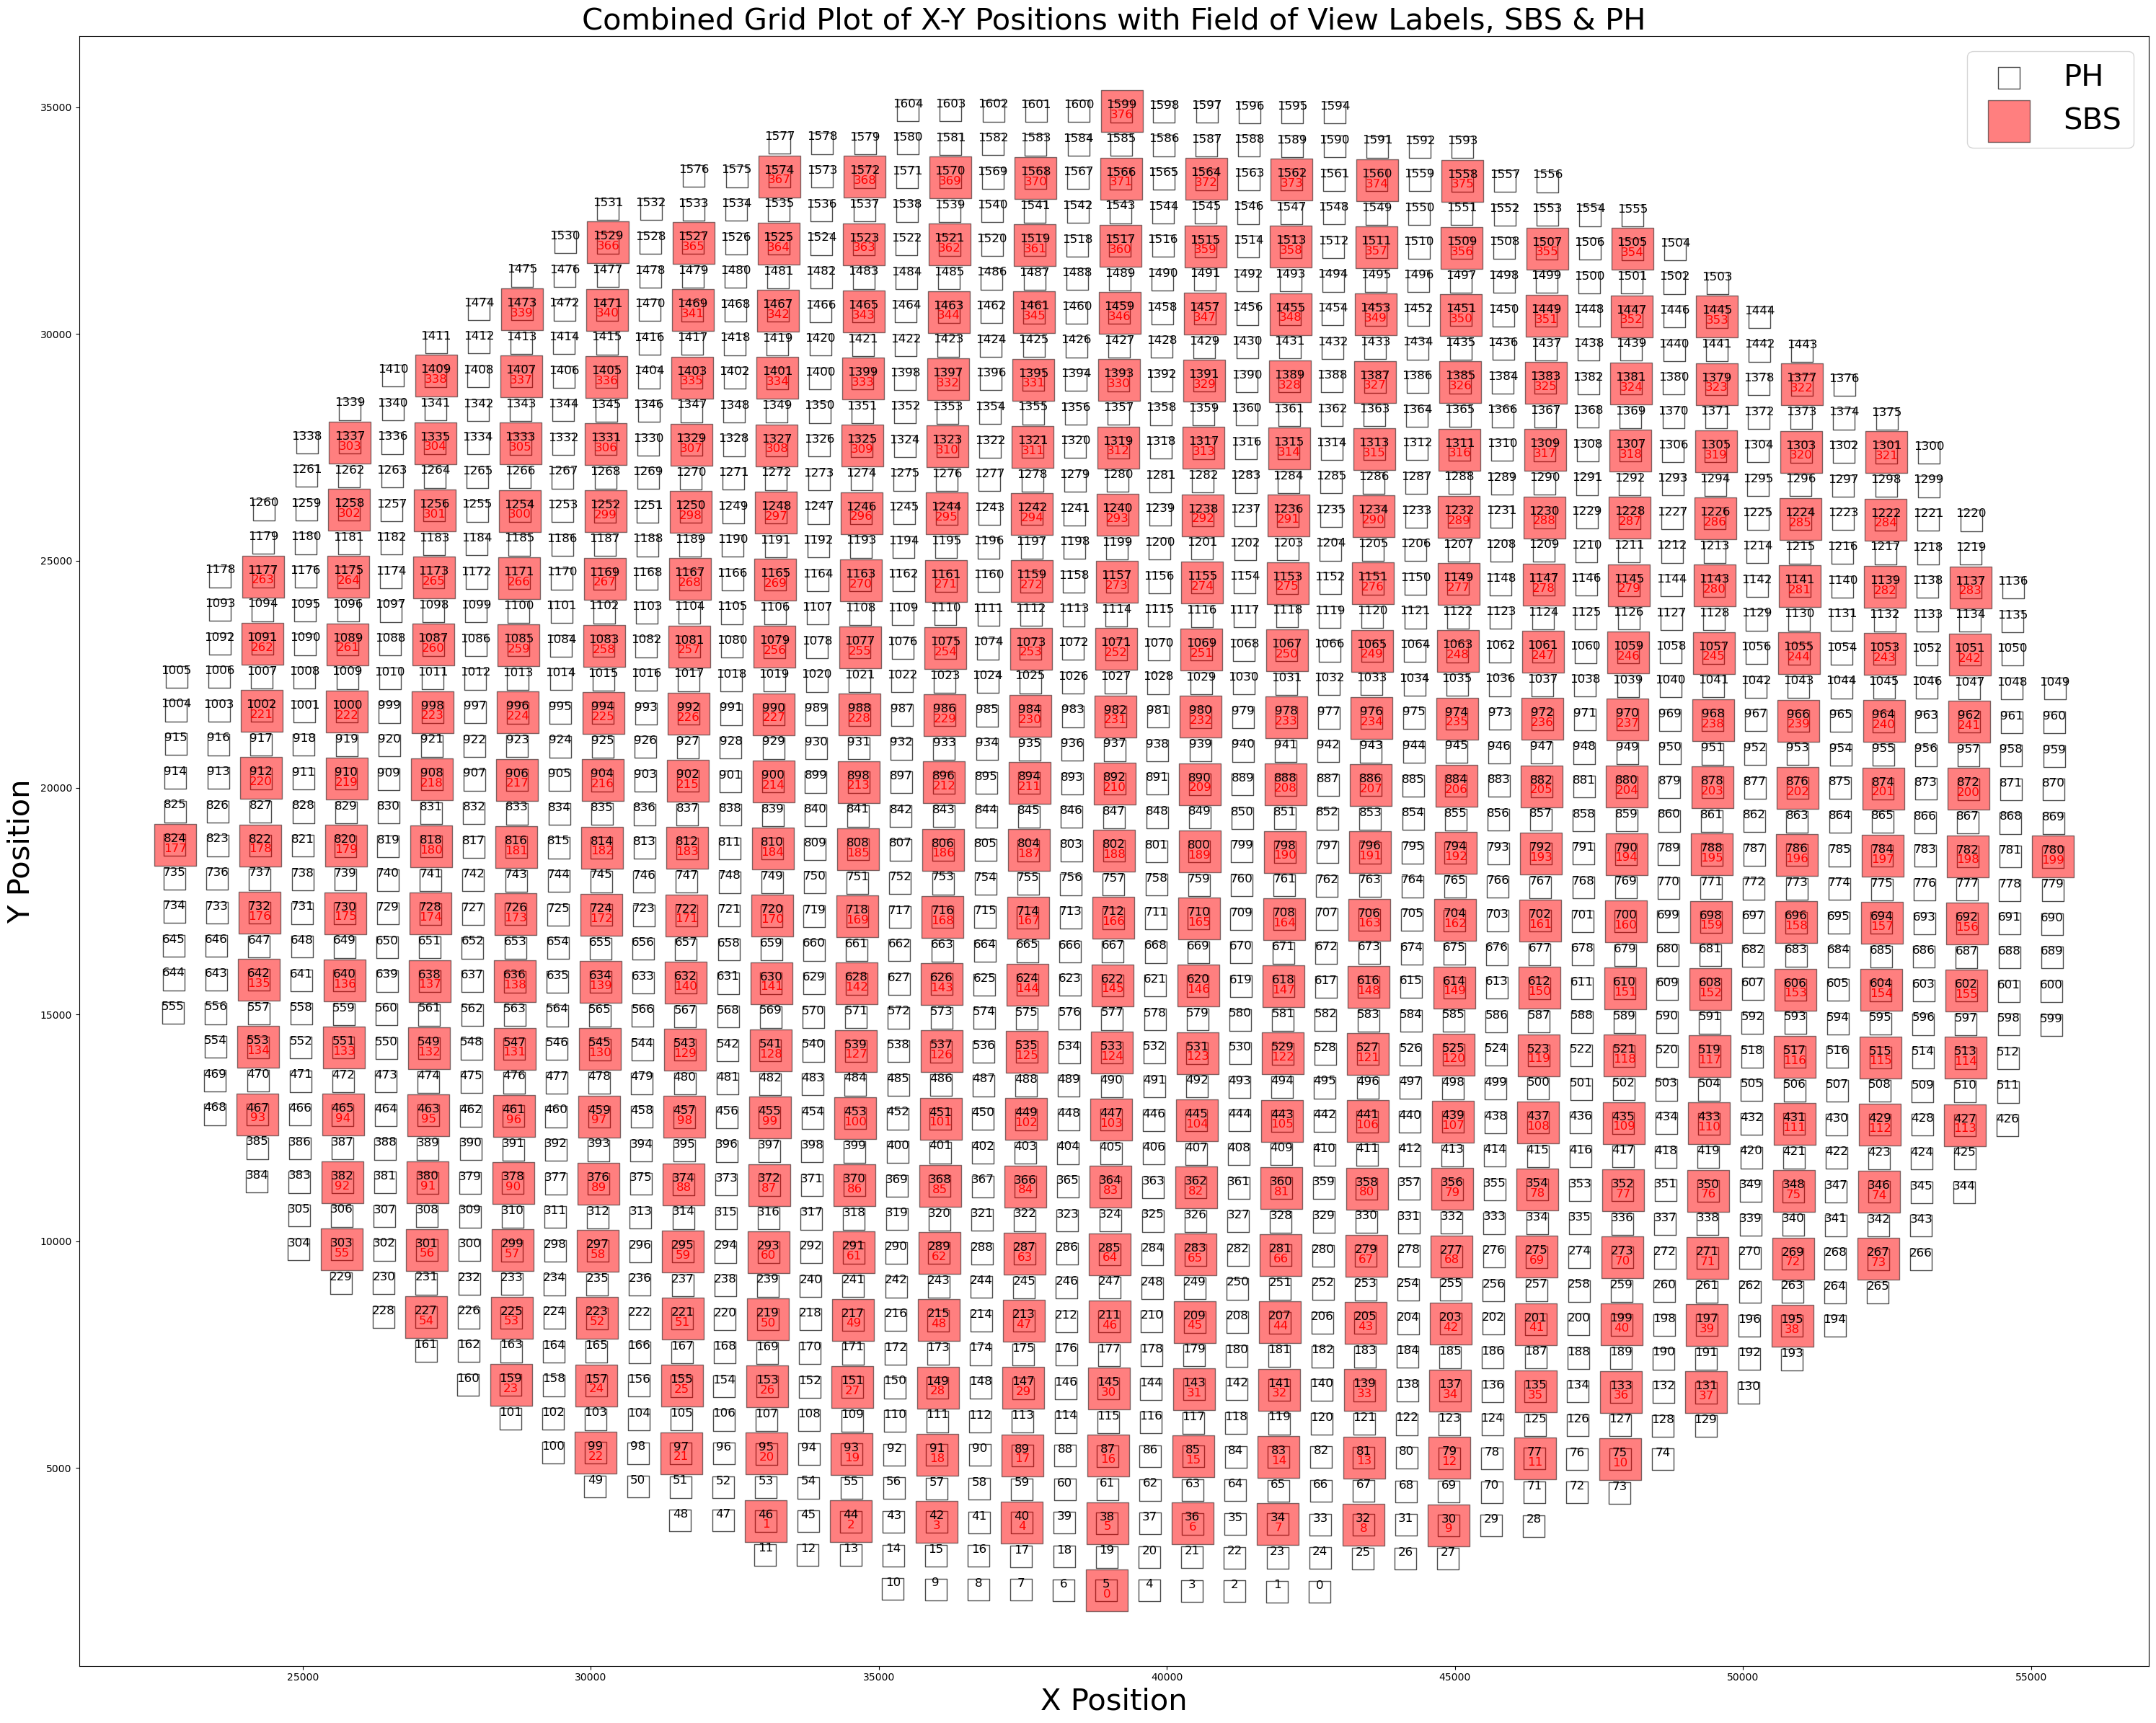

In [77]:
plt.figure(figsize=(30, 24))

# Scatter plot for PH data
plt.scatter(
    ph_test_metadata["x_pos"],
    ph_test_metadata["y_pos"],
    s=450,
    c="white",
    marker="s",
    edgecolors="black",
    linewidths=1,
    alpha=0.7,
    label="PH",
)

# Label each PH point with the 'field_of_view' variable
for i, txt in enumerate(ph_test_metadata["tile"]):
    plt.annotate(
        txt,
        (ph_test_metadata["x_pos"].iloc[i], ph_test_metadata["y_pos"].iloc[i]),
        textcoords="offset points",
        xytext=(0, 3),
        ha="center",
        fontsize=12,
        color="black",
    )

# Scatter plot for SBS data
plt.scatter(
    sbs_test_metadata["x_pos"],
    sbs_test_metadata["y_pos"],
    s=1800,
    c="red",
    marker="s",
    edgecolors="black",
    linewidths=1,
    alpha=0.5,
    label="SBS",
)

# Label each SBS point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata["tile"]):
    plt.annotate(
        txt,
        (sbs_test_metadata["x_pos"].iloc[i], sbs_test_metadata["y_pos"].iloc[i]),
        textcoords="offset points",
        xytext=(0, -7),
        ha="center",
        fontsize=12,
        color="red",
    )

# Set labels and title
plt.xlabel("X Position", fontsize=30)
plt.ylabel("Y Position", fontsize=30)
plt.title(
    "Combined Grid Plot of X-Y Positions with Field of View Labels, SBS & PH",
    fontsize=30,
)

plt.legend(fontsize=30)
plt.tight_layout()
plt.show()